# 07 - Part B - Product search using Vertex Matching engine


Make sure your are running this notebook in the newly created in the VPC.

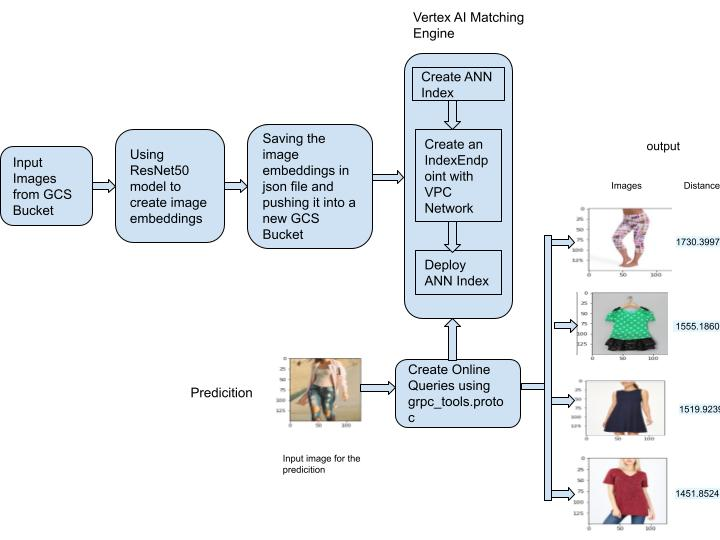

## Overview

This example demonstrates how to use the GCP ANN Service. It is a high scale, low latency solution, to find similar vectors (or more specifically "embeddings") for a large corpus. Moreover, it is a fully managed offering, further reducing operational overhead. It is built upon [Approximate Nearest Neighbor (ANN) technology](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html) developed by Google Research.


### Objective

In this notebook, you will learn how to create Approximate Nearest Neighbor (ANN) Index, query against indexes, and validate the performance of the index. 

The steps performed include:

1) Create ANN Index
2) Create an IndexEndpoint with VPC Network
3) Deploy ANN Index
4) Perform online query

For the purpose of this workshop, the VPC is already created, the notebooks are created in the VPC itself

### Before you get started

Create two separate Cloud Storage buckets. In the `REGION` `us-central1`.
1) GCS BUCKET 1: For input image data. Unzip the folder `images_300` (is provided via email) and upload it to this bucket 
2) GCS BUCKET 2 : Keep the second bucket empty to store the json file which is created later in this notebook.

Upload the `images_300` folder (is provided via email) to the same instance where this notebook is been run.
Upload the `try_input` folder which consists of a set of 5 images which can be used for the prediction (is provided via email) to the same instance where this notebook is been run.

In [2]:
# Replace with the name of the GCS bucket 1.
BUCKET_NAME1 = "zulily-image-data001"
# Replace with the name of the GCS bucket 2.
BUCKET_NAME2 = "gs://zulily_engine_001"

# 1 - Setup


### Installations

Download and install the latest (preview) version of the Vertex SDK for Python and some other required libraries.

In [2]:
! pip install -U git+https://github.com/googleapis/python-aiplatform.git@main-test --user

  Cloning https://github.com/googleapis/python-aiplatform.git (to revision main-test) to /tmp/pip-req-build-c0submf3
  Running command git clone --filter=blob:none --quiet https://github.com/googleapis/python-aiplatform.git /tmp/pip-req-build-c0submf3
  Running command git checkout -b main-test --track origin/main-test
  Switched to a new branch 'main-test'
  Branch 'main-test' set up to track remote branch 'main-test' from 'origin'.
  Resolved https://github.com/googleapis/python-aiplatform.git to commit 59808e63aa07a725de03721ecdd4efef9e1b33e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 22.6 MB/s eta 0:00:00
  Created wheel for google-cloud-aiplatform: filename=google_cloud_aiplatform-0.7.1-py2.py3-none-any.whl size=1696808 sha256=6862ff25ecf1fb5827eff91e1211a2dedbc8dde2

Install the `grpcio-tools` for querying against the index. 

In [3]:
! pip install -U grpcio-tools --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 94.7 MB/s eta 0:00:00:00:01


In [4]:
!pip install tensorflow==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.0/495.0 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 103.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 72.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [5]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 20.0 MB/s eta 0:00:0000:0100:01


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

### Importing Libraries

In [3]:
import tensorflow as tf
import keras
from google.cloud import storage
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__


import time
from tqdm import tqdm
import grpc
from google.cloud import aiplatform_v1beta1
from google.protobuf import struct_pb2
import numpy as np

2022-02-18 18:38:52.789527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 18:38:52.789569: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


1) In the below cell keep the `REGION` which is been used 
2) No need to change `ENPOINT` 
3) In the `NETWORK_NAME` copy paste the name of newly created VPC
4) Copy paste the `PROJECT_ID` you are working in
5) Keep remaining as it is.

In [4]:
REGION = "us-central1"
ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
NETWORK_NAME = "matching-engine-ann-vpc"  # @param {type:"string"}

PROJECT_ID = 'q-gcp-4639-zulily-01-22-02'
AUTH_TOKEN = !gcloud auth print-access-token
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
print(PROJECT_NUMBER)
PROJECT_NUMBER = PROJECT_NUMBER[0]

PARENT = "projects/{}/locations/{}".format(PROJECT_ID, REGION)

!gcloud config set project {PROJECT_ID}
!gcloud config set ai_platform/region {REGION}

['354129749410']
Updated property [core/project].
Updated property [ai_platform/region].


# 2 - Model Building 
#### Vector Generation:

1.   Convert images to embeddings
2.   Conduct Transfer Learning from ResNet
3.   Use Approximate Nearest Neighbors and embeddings centroid detection to obtain most similar images based on the embeddings from step 3.

Results: Given a any image, we can generate recommendations for it instantly.

ResNet-50 is a convolutional neural network that is 50 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories.

In [5]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.applications.resnet50.ResNet50(include_top = False, 
                                                            weights = 'imagenet'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    print(model.summary())
    
    return model

module = get_model()

2022-02-18 18:39:12.314522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2022-02-18 18:39:12.314573: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-18 18:39:12.314616: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (test-vm-03): /proc/driver/nvidia/version does not exist
2022-02-18 18:39:12.315118: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
None


# 3 - Preparing the data

In [6]:
# @title Helper functions for loading image (hidden)
def load_images(image_name):
    '''Loading image from GCS bucket and formating so that can be used for dataset creation.
    
    Args:
    image_name: File path of image.
    '''
    img = tf.io.decode_jpeg(tf.io.read_file(image_name))
    img = tf.image.resize(img, [224,224],tf.image.ResizeMethod.BICUBIC)
    return img, image_name

def get_features(images):
    '''Get features (embeddings) extracted from image
    
    Args:
    images: Dataset of images is passed
    '''
    features = module(images)
    return features.numpy()

Creating the vectors for the input images and the generating it in the dataframe format

1) In the below function change the `BUCKET_NAME1`- the bucket where your input images are kept. 
2) And in `image_data_path` replace `/images_500/images_300/` with whatever folder you have kept the input images inside the bucket

In [7]:
def create_vec(dataset, filenames, L):
    '''Creating vectors for the dataset and saving them in batches of 64
    
    Args:
    dataset: The dataset created by passing images and converting them into numpy arrays.
    filenames: Name of the image
    L: Number of batches
    '''
    embedding_data = dict()
    
    df = pd.DataFrame({" ": pd.NA}, index=filenames)
    for index, (images, filenames) in enumerate(dataset.take(L)):
        results = get_features(images)
        output_file =str(index)
        filenames = [file.decode('utf-8') for file in filenames.numpy().tolist()]
        result_data = [re for re in results]
            
        df.loc[filenames, " "] = result_data
    return df #embedding_data


#change the bucket name and path where your input images are stored in the bucket
BUCKET_NAME1 = "zulily-image-data001"
image_data_path = "gs://"+ BUCKET_NAME1 + "/images_500/images_300/"
BATCH_SIZE=64
def generate_vectors(image_data_path):
    '''Generate vectors and stores them in batches of 64 and also create a dataframe where all indices are available for further use
    
    Args:
    input_data_path: The path for GCS bucket where images are available
    BUCKET_NAME1: Name of the bucket
    '''
    
    filenames = tf.io.gfile.glob(image_data_path+"*.jpg")
    L=(len(filenames)//BATCH_SIZE)+1
    print(len(filenames))
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(load_images, tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    df = create_vec(dataset,filenames,L)
    return df
    
#generate_vectors()
df_data = generate_vectors(image_data_path)

300


In this notebook we will convert the dataframe into a proper format.

In [8]:
def proper_dataframe(df_data):
    '''
    Formatting the dataframe in a way from which transferring to json format will get easy
    '''
    
    df_index = df_data.reset_index()
    df_index.columns = ['url', 'embedding']
    df_index['id'] = np.arange(len(df_index))
    df_index = df_index[["id", "url", "embedding"]]
    return df_index
    
df_index = proper_dataframe(df_data)

Saving the image embedding data in JSONL format.

In [9]:
def create_data(df_index):
    '''
    Tranfering the dataframe (df_index) into json file (new_result.json) in the local instance
    '''
    df_index = df_index.drop(['url'], axis = 1)
    with open('new_result.json', 'w') as new_file:
        for i in df_index.index:
            json_object = json.dumps({"id": str(df_index.id[i]), "embedding": df_index.embedding[i].tolist()})
            new_file.write(json_object)
            new_file.write('\n')
            
create_data(df_index)     

Don't give the same `BUCKET_NAME2` which you gave for the input image data, give another bucket which is been only created to store embedding of image data in json file.
`USER_NAME` can be same.

In [10]:
BUCKET_NAME2 = "gs://zulily_engine_001"
USER_NAME = 'project'

Removing the embedding json file from GCS if already exists.

In [11]:
! gsutil rm -r {BUCKET_NAME2}/new_result.json

Removing gs://zulily_engine_001/new_result.json#1645207797208597...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              


Upload the training data to GCS.

In [12]:
! gsutil -m cp new_result.json {BUCKET_NAME2}/new_result.json

Copying file://new_result.json [Content-Type=application/json]...
/ [1/1 files][ 10.4 MiB/ 10.4 MiB] 100% Done                                    
Operation completed over 1 objects/10.4 MiB.                                     


Checking the bucket whether json file is successfully uploaded

In [13]:
! gsutil ls {BUCKET_NAME2}

gs://zulily_engine_001/new_result.json


# 4 - Create Indexes (45 minutes)

### Create ANN Index (for Production Usage)

An index for efficient approximate nearest neighbor search. Abstract: We explore the problem of approximate nearest neighbor searches. We propose an index structure, the ANN-tree (approximate nearest neighbor tree) to solve this problem. The ANN-tree supports high accuracy nearest neighbor search.

In [14]:
index_client = aiplatform_v1beta1.IndexServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)

In [15]:
DIMENSIONS = 2048
DISPLAY_NAME = "zulily_engine" + "_" + "_".join(REGION.split('-'))

Create the ANN index configuration:

Please read the documentation to understand the various configuration parameters that can be used to tune the index


In [16]:
treeAhConfig = struct_pb2.Struct(
    fields={
        "leafNodeEmbeddingCount": struct_pb2.Value(number_value=500),
        "leafNodesToSearchPercent": struct_pb2.Value(number_value=7),
    }
)

algorithmConfig = struct_pb2.Struct(
    fields={"treeAhConfig": struct_pb2.Value(struct_value=treeAhConfig)}
)

config = struct_pb2.Struct(
    fields={
        "dimensions": struct_pb2.Value(number_value=DIMENSIONS),
        "approximateNeighborsCount": struct_pb2.Value(number_value=150),
        "distanceMeasureType": struct_pb2.Value(string_value="DOT_PRODUCT_DISTANCE"),
        "algorithmConfig": struct_pb2.Value(struct_value=algorithmConfig),
    }
)

metadata = struct_pb2.Struct(
    fields={
        "config": struct_pb2.Value(struct_value=config),
        "contentsDeltaUri": struct_pb2.Value(string_value=BUCKET_NAME2),
    }
)

ann_index = {
    "display_name": DISPLAY_NAME,
    "description": USER_NAME + " " + "ANN index" + " " + REGION,
    "metadata": struct_pb2.Value(struct_value=metadata),
}

In [17]:
ann_index = index_client.create_index(parent=PARENT, index=ann_index)

In [18]:
# Poll the operation until it's done successfullly.
# This will take ~45 min.

while True:
    if ann_index.done():
        break
    print("Poll the operation to create index...")
    time.sleep(30)

Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the operation to create index...
Poll the ope

In [19]:
INDEX_RESOURCE_NAME = ann_index.result().name
INDEX_RESOURCE_NAME

'projects/354129749410/locations/us-central1/indexes/1544699487815991296'

# 5 - Create an IndexEndpoint with VPC Network

#### VPC network overview
A Virtual Private Cloud (VPC) network is a virtual version of a physical network, implemented inside of Google's production network, using Andromeda. A VPC network provides the following:

Provides connectivity for your Compute Engine virtual machine (VM) instances, including Google Kubernetes Engine (GKE) clusters, App Engine flexible environment instances, and other Google Cloud products built on Compute Engine VMs.
Offers native Internal TCP/UDP Load Balancing and proxy systems for Internal HTTP(S) Load Balancing.
Connects to on-premises networks using Cloud VPN tunnels and Cloud Interconnect attachments.
Distributes traffic from Google Cloud external load balancers to backends.
Projects can contain multiple VPC networks. Unless you create an organizational policy that prohibits it, new projects start with a default network (an auto mode VPC network) that has one subnetwork (subnet) in each region.

In [20]:
index_endpoint_client = aiplatform_v1beta1.IndexEndpointServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)

In [21]:
VPC_NETWORK_NAME = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, NETWORK_NAME)
VPC_NETWORK_NAME

'projects/354129749410/global/networks/matching-engine-ann-vpc'

In [22]:
index_endpoint = {
    "display_name": USER_NAME + "_" + "index_endpoint_for_workshop" + "_" + "_".join(REGION.split('-')),
    "network": VPC_NETWORK_NAME,
}

In [23]:
r = index_endpoint_client.create_index_endpoint(
    parent=PARENT, index_endpoint=index_endpoint
)

In [24]:
r.result()

name: "projects/354129749410/locations/us-central1/indexEndpoints/6878087346529501184"

In [25]:
INDEX_ENDPOINT_NAME = r.result().name
INDEX_ENDPOINT_NAME

'projects/354129749410/locations/us-central1/indexEndpoints/6878087346529501184'

# 6 - Deploy ANN Index (15-45 minutes)

Before you use an index to serve online vector matching queries, you must deploy the Index to an IndexEndpoint within your VPC Network Peering network. The first step is to create an IndexEndpoint. You can deploy more than one index to an IndexEndpoint that shares the same VPC network.

##### Change this `ann_index_me_deployed_05` in the below line only if you are creating new index or runing the entire code from the start.

In [30]:
DEPLOYED_INDEX_ID = USER_NAME + "_" + "ann_index_me_deployed_09" + "_" + "_".join(REGION.split('-'))

In [31]:
deploy_ann_index = {
    "id": DEPLOYED_INDEX_ID,
    "display_name": DEPLOYED_INDEX_ID,
    "index": INDEX_RESOURCE_NAME,
}

In [32]:
r = index_endpoint_client.deploy_index(
    index_endpoint=INDEX_ENDPOINT_NAME, deployed_index=deploy_ann_index
)

In [33]:
# Poll the operation until it's done successfullly.

while True:
    if r.done():
        break
    print("Poll the operation to deploy index...")
    time.sleep(30)

Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...
Poll the operation to deploy index...


In [34]:
r.result()

deployed_index {
  id: "project_ann_index_me_deployed_09_us_central1"
}

## Create Online Queries

After you built your indexes, you may query against the deployed index through the online querying gRPC API (Match service) within the virtual machine instances from the same region (for example 'us-central1' in this tutorial).  

The way a client uses this gRPC API is by folowing steps:

* Write `match_service.proto` locally
* Clone the repository that contains the dependencies of match_service.proto

* Compile the protocal buffer (see below)
* Obtain the index endpoint
* Use a code-generated stub to make the call, passing the parameter values

In [35]:
!rm -rf third_party

E0218 19:34:10.776599573    2723 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [36]:
! mkdir third_party

E0218 19:34:10.979724933    2723 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [37]:
! git clone https://github.com/googleapis/googleapis.git ./third_party/googleapis/

Cloning into './third_party/googleapis'...


E0218 19:34:16.303074817    2723 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


remote: Enumerating objects: 169917, done.
remote: Counting objects: 100% (7004/7004), done.
remote: Compressing objects: 100% (2377/2377), done.
remote: Total 169917 (delta 4844), reused 6477 (delta 4505), pack-reused 162913
Receiving objects: 100% (169917/169917), 157.80 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (148552/148552), done.


In [38]:
%%writefile match_service.proto

syntax = "proto3";

package google.cloud.aiplatform.container.v1beta1;

import "google/rpc/status.proto";

// MatchService is a Google managed service for efficient vector similarity
// search at scale.
service MatchService {
  // Returns the nearest neighbors for the query. If it is a sharded
  // deployment, calls the other shards and aggregates the responses.
  rpc Match(MatchRequest) returns (MatchResponse) {}

  // Returns the nearest neighbors for batch queries. If it is a sharded
  // deployment, calls the other shards and aggregates the responses.
  rpc BatchMatch(BatchMatchRequest) returns (BatchMatchResponse) {}
}

// Parameters for a match query.
message MatchRequest {
  // The ID of the DeploydIndex that will serve the request.
  // This MatchRequest is sent to a specific IndexEndpoint of the Control API,
  // as per the IndexEndpoint.network. That IndexEndpoint also has
  // IndexEndpoint.deployed_indexes, and each such index has an
  // DeployedIndex.id field.
  // The value of the field below must equal one of the DeployedIndex.id
  // fields of the IndexEndpoint that is being called for this request.
  string deployed_index_id = 1;

  // The embedding values.
  repeated float float_val = 2;

  // The number of nearest neighbors to be retrieved from database for
  // each query. If not set, will use the default from
  // the service configuration.
  int32 num_neighbors = 3;

  // The list of restricts.
  repeated Namespace restricts = 4;

  // Crowding is a constraint on a neighbor list produced by nearest neighbor
  // search requiring that no more than some value k' of the k neighbors
  // returned have the same value of crowding_attribute.
  // It's used for improving result diversity.
  // This field is the maximum number of matches with the same crowding tag.
  int32 per_crowding_attribute_num_neighbors = 5;

  // The number of neighbors to find via approximate search before
  // exact reordering is performed. If not set, the default value from scam
  // config is used; if set, this value must be > 0.
  int32 approx_num_neighbors = 6;

  // The fraction of the number of leaves to search, set at query time allows
  // user to tune search performance. This value increase result in both search
  // accuracy and latency increase. The value should be between 0.0 and 1.0. If
  // not set or set to 0.0, query uses the default value specified in
  // NearestNeighborSearchConfig.TreeAHConfig.leaf_nodes_to_search_percent.
  int32 leaf_nodes_to_search_percent_override = 7;
}

// Response of a match query.
message MatchResponse {
  message Neighbor {
    // The ids of the matches.
    string id = 1;

    // The distances of the matches.
    double distance = 2;
  }
  // All its neighbors.
  repeated Neighbor neighbor = 1;
}

// Parameters for a batch match query.
message BatchMatchRequest {
  // Batched requests against one index.
  message BatchMatchRequestPerIndex {
    // The ID of the DeploydIndex that will serve the request.
    string deployed_index_id = 1;

    // The requests against the index identified by the above deployed_index_id.
    repeated MatchRequest requests = 2;

    // Selects the optimal batch size to use for low-level batching. Queries
    // within each low level batch are executed sequentially while low level
    // batches are executed in parallel.
    // This field is optional, defaults to 0 if not set. A non-positive number
    // disables low level batching, i.e. all queries are executed sequentially.
    int32 low_level_batch_size = 3;
  }

  // The batch requests grouped by indexes.
  repeated BatchMatchRequestPerIndex requests = 1;
}

// Response of a batch match query.
message BatchMatchResponse {
  // Batched responses for one index.
  message BatchMatchResponsePerIndex {
    // The ID of the DeployedIndex that produced the responses.
    string deployed_index_id = 1;

    // The match responses produced by the index identified by the above
    // deployed_index_id. This field is set only when the query against that
    // index succeed.
    repeated MatchResponse responses = 2;

    // The status of response for the batch query identified by the above
    // deployed_index_id.
    google.rpc.Status status = 3;
  }

  // The batched responses grouped by indexes.
  repeated BatchMatchResponsePerIndex responses = 1;
}

// Namespace specifies the rules for determining the datapoints that are
// eligible for each matching query, overall query is an AND across namespaces.
message Namespace {
  // The string name of the namespace that this proto is specifying,
  // such as "color", "shape", "geo", or "tags".
  string name = 1;

  // The allowed tokens in the namespace.
  repeated string allow_tokens = 2;

  // The denied tokens in the namespace.
  // The denied tokens have exactly the same format as the token fields, but
  // represents a negation. When a token is denied, then matches will be
  // excluded whenever the other datapoint has that token.
  //
  // For example, if a query specifies {color: red, blue, !purple}, then that
  // query will match datapoints that are red or blue, but if those points are
  // also purple, then they will be excluded even if they are red/blue.
  repeated string deny_tokens = 3;
}

Writing match_service.proto


Compile the protocol buffer, and then `match_service_pb2.py` and `match_service_pb2_grpc.py` are generated.

In [39]:
! python -m grpc_tools.protoc -I=. --proto_path=third_party/googleapis --python_out=. --grpc_python_out=. match_service.proto

E0218 19:34:54.180021456    2723 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Obtain the Private Endpoint: 

`DEPLOYED_INDEX_ID` - Copy from the Deploy ANN Index r.result() output and paste it here remaining can be unchanged.

Each DeployedIndex has a `DEPLOYED_INDEX_SERVER_IP`, which you can retrieve by listing IndexEndpoints. To query a `DeployedIndex`, connect to its DEPLOYED_INDEX_SERVER_IP at port 10000 

In [40]:
import match_service_pb2
import match_service_pb2_grpc

DEPLOYED_INDEX_SERVER_IP = (
    list(index_endpoint_client.list_index_endpoints(parent=PARENT))[0]
    .deployed_indexes[0]
    .private_endpoints.match_grpc_address
)

DEPLOYED_INDEX_SERVER_IP

DEPLOYED_INDEX_ID = "project_ann_index_me_deployed_04_us_central1"
channel = grpc.insecure_channel("{}:10000".format(DEPLOYED_INDEX_SERVER_IP))
stub = match_service_pb2_grpc.MatchServiceStub(channel)

Test your query:

# 7 - Prediction

Give the try input image path below for the predicition

In [41]:
image_data_path_01 = "/home/jupyter/matching-engine/try_input/87688458.0.jpg"

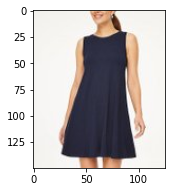

In [42]:
def plot_input_image(image_data_path):
    '''
    plotting the images we got from the output as per the nearest distance and id
    '''
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 2
    img=cv2.imread(image_data_path) #give local path where images are stored
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img)
    plt.show()
    
plot_input_image(image_data_path_01)

In [43]:
BATCH_SIZE = 1
def create_vec(dataset, filenames, L):
    '''Creating vectors for the dataset and saving them in batches of 64
    
    Args:
    dataset: The dataset created by passing images and converting them into numpy arrays.
    filenames: Name of the image
    L: Number of batches
    '''
    embedding_data = dict()
    
    df = pd.DataFrame({" ": pd.NA}, index=filenames)
    for index, (images, filenames) in enumerate(dataset.take(L)):
        results = get_features(images)
        output_file =str(index)
        filenames = [file.decode('utf-8') for file in filenames.numpy().tolist()]
        result_data = [re for re in results]
            
        df.loc[filenames, " "] = result_data
    #print(embedding_data)
    return df #embedding_data

In [44]:
def generate_vectors(image_data_path):
    '''Generate vectors and stores them in batches of 64 and also create a dataframe where all indices are available for further use
    
    Args:
    image_data_path: The path for GCS bucket where images are available
    '''
    
    filenames = tf.io.gfile.glob(image_data_path)
        
    print(len(filenames))
    L=(len(filenames)//BATCH_SIZE)+1
    print(L)
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(load_images, tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    df = create_vec(dataset,filenames,L)
    output = df.values[0][0].tolist()
    return output
    
#generate_vectors()
output = generate_vectors(image_data_path_01)

1
2


In [45]:
k=5
def get_results(input_token, num=k):
    '''
    Matching the embedding for the input image with the deployed index 
    to predict the nearest id and distance and the saving it in the csv format
    '''
    #query = embedding_model[input_token]
    query = input_token
    request = match_service_pb2.MatchRequest(num_neighbors=num)
    request.deployed_index_id = DEPLOYED_INDEX_ID
    for val in query:
        request.float_val.append(val)

    response = stub.Match(request)
    #df = pd.DataFrame()
    with open('result.csv', 'w') as new_file:
        for i in range(len(response.neighbor)):
            print(f"{response.neighbor[i].id:10s}", ",", f"{response.neighbor[i].distance:<20}", file=new_file)

get_results(output)

In [46]:
def create_df():
    '''
    Reading the earlier saved csv file and creating dataframe out of it then formatting it
    for the better view and understanding of the output
    '''
    
    df = pd.read_csv('result.csv', header=None)
    df.columns = ['id', 'distance']
    df_file_result = pd.DataFrame({"id":[], "url":[], "distance":[]})
    for i, j in zip(df["id"], df["distance"]):
        for m, n in zip(df_index["id"], df_index["url"]):
            if i==m:
                df_file_result = df_file_result.append({"id":str(i), "url":n, "distance":j}, ignore_index =True)
    return df_file_result

df_file_result = create_df()

In [47]:
df_file_result

id                                                url     distance
0  21  gs://zulily-image-data001/images_500/images_30...  1432.565430
1  72  gs://zulily-image-data001/images_500/images_30...  1401.568115

In the below cell change this path `/home/jupyter/data/` to wherever you have saved the input data images in the instance

In [49]:
def plot_image(df_file_result):
    '''
    plotting the images we got from the output as per the nearest distance and id
    '''
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 2
    for i in df_file_result.index:
        x=df_file_result.url[i].split("/")[-1]
        img=cv2.imread('/home/jupyter/matching-engine/images_300/'+x) #give local path where images are stored
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()

In [50]:
plot_image(df_file_result)